# Nucleus Detection

### Next steps

* Train on data that isn't just the 256x256
* Work out a better way of deciding what is good (not just picking a cutoff..)
* the paper mentions something about how to init weights

### Mid term plans

* Data augmentation

# Imports

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import data_loaders, prepare_submission, net, imcut
import plot_helpers.plot as plot
from evaluations.iou import log_iou, iou_loss

import helpers as h

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from sklearn import model_selection
from tqdm import tqdm

# Data

In [9]:
train_raw, train_keys_raw = data_loaders.training_images()
summary_masks_raw, weights_raw = data_loaders.masks_and_weights("one_and_two_term_weights")

In [10]:
train_shapes = {}
for i in range(len(train_raw)):
    img = train_raw[i]
    weight = weights_raw[i]
    mask = summary_masks_raw[i]
    if img.shape[0] < 256 or img.shape[1] < 256: raise Exception("We can't handle small training images")
    try:
        train_shapes[img.shape].append((img, weight, mask))
    except:
        train_shapes[img.shape] = [(img, weight, mask)]

In [11]:
train, weights, summary_masks = [], [], []
for shp, images in train_shapes.items():
    y_cut, x_cut = imcut.training_patchify(shp)
    for img_index in range(len(images)):
        for i in range(len(y_cut)):
            for j in range(len(x_cut)):
                train.append(images[img_index][0][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])
                weights.append(images[img_index][1][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])
                summary_masks.append(images[img_index][2][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])

In [12]:
trainT, valid, weightsT, valid_weights, summary_masksT, valid_summary_masks = model_selection.train_test_split(train, weights, summary_masks, test_size=0.2)

trainV, validV = h.tensorfy(trainT), h.tensorfy(valid)
weightsV, valid_weightsV = h.tensorfy(weightsT), h.tensorfy(valid_weights)
summary_masksV, valid_summary_masksV = h.tensorfy(summary_masksT), h.tensorfy(valid_summary_masks)

assert summary_masksV.shape == weightsV.shape and trainV.shape == weightsV.shape
print(summary_masksV.shape, type(trainV))

torch.Size([1779, 1, 256, 256]) <class 'torch.FloatTensor'>


### Sanity check

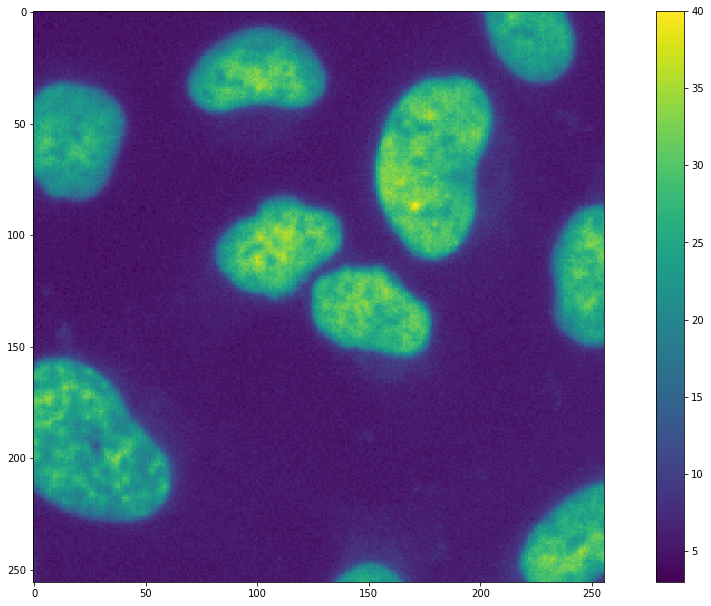

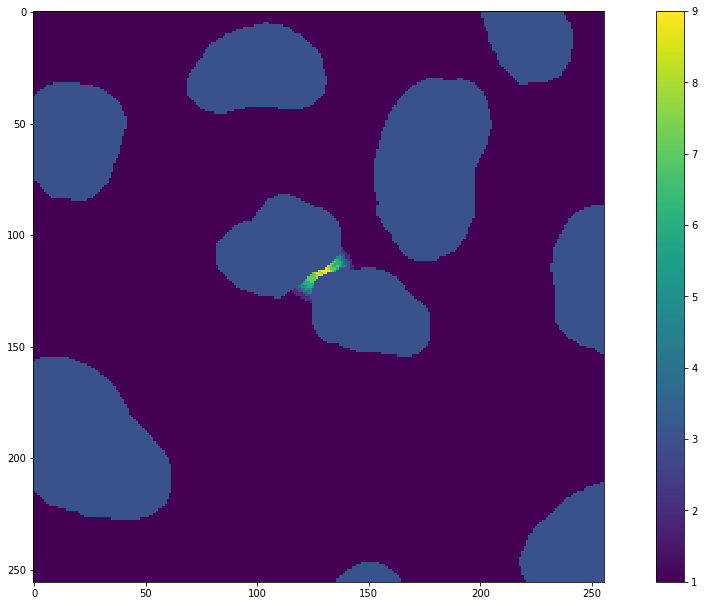

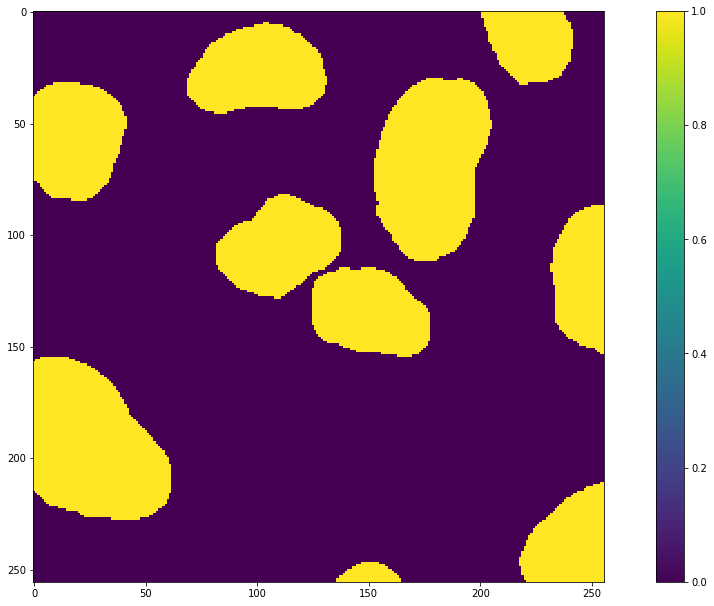

In [12]:
i = 800
plot(trainT[i])
plot(weightsT[i])
plot(summary_masksT[i])

# Exploration

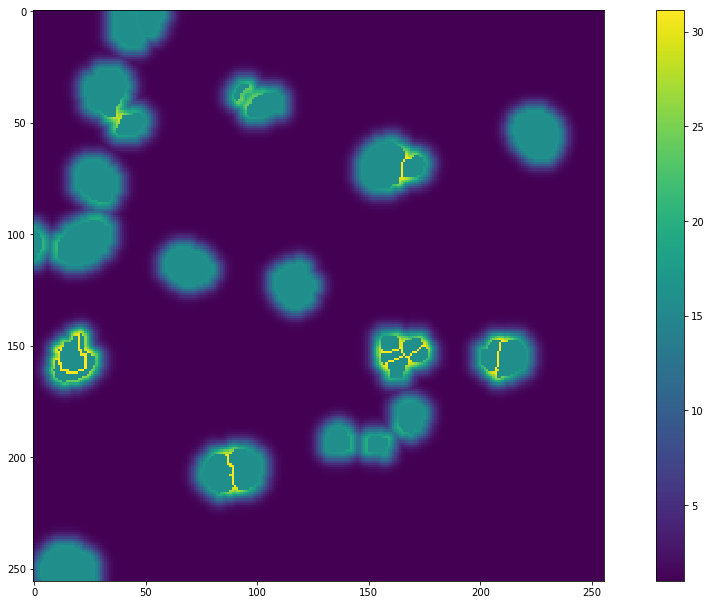

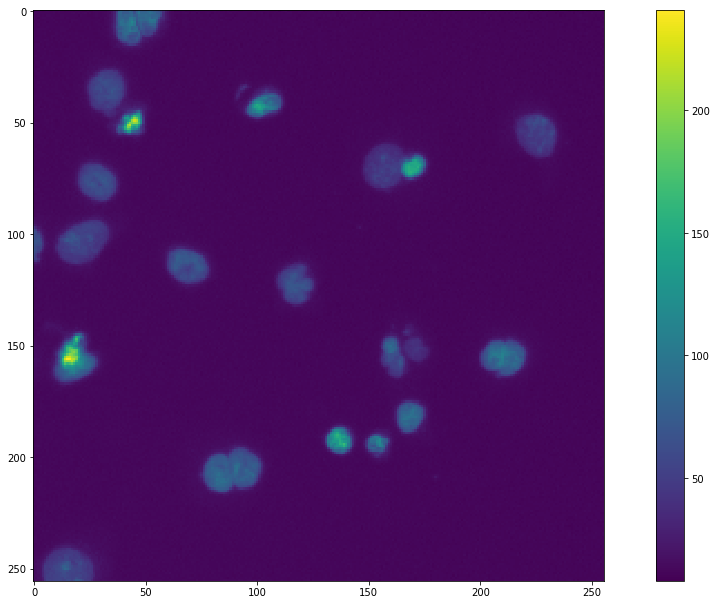

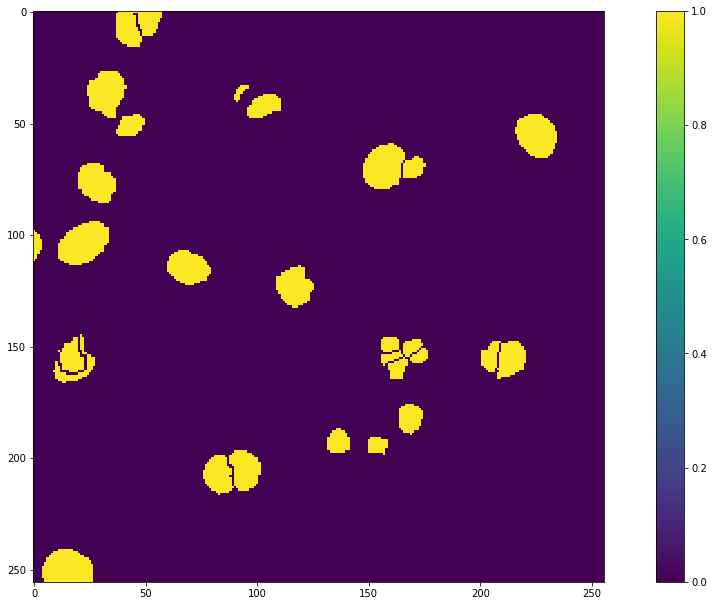

In [13]:
for i in [weights, train, summary_masks]:
    plot.imshow(i[3])


# Train

In [14]:
n = net.u_net().cuda()
# Large momentum because our batch size is small. We want many of the recent images to impact our move.
optimizer = torch.optim.SGD(n.parameters(), lr=0.000001, momentum=0.99)
batchsize = 5
losses = []
epoch_num = 0

In [ ]:
n.train()
for epoch in range(5):
    epoch_num += 1  
    shuffle = torch.randperm(len(trainV))
    trainV, weightsV, summary_masksV = trainV[shuffle], weightsV[shuffle], summary_masksV[shuffle]
    t = tqdm(range(0, len(trainV), batchsize), desc="{} Epoch".format(epoch_num))
    for i in t:
        # Define input data
        inp = trainV[i:i+batchsize]
        inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()

        # Define expected data and weights
        weight = Variable(weightsV[i:i+batchsize]).cuda()
        exp = Variable(summary_masksV[i:i+batchsize]).cuda()

        # Ready net
        optimizer.zero_grad()

        # Run net and get output ready for loss and backgrad
        out = n(inp)[:,:,2:-2,2:-2]
        
        # Calculate loss
        loss = (weight * (exp - out)**2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy()[0])

15 Epoch:  30%|███       | 108/356 [00:47<01:49,  2.26it/s]

# Post train sanity checks

(0, 2)

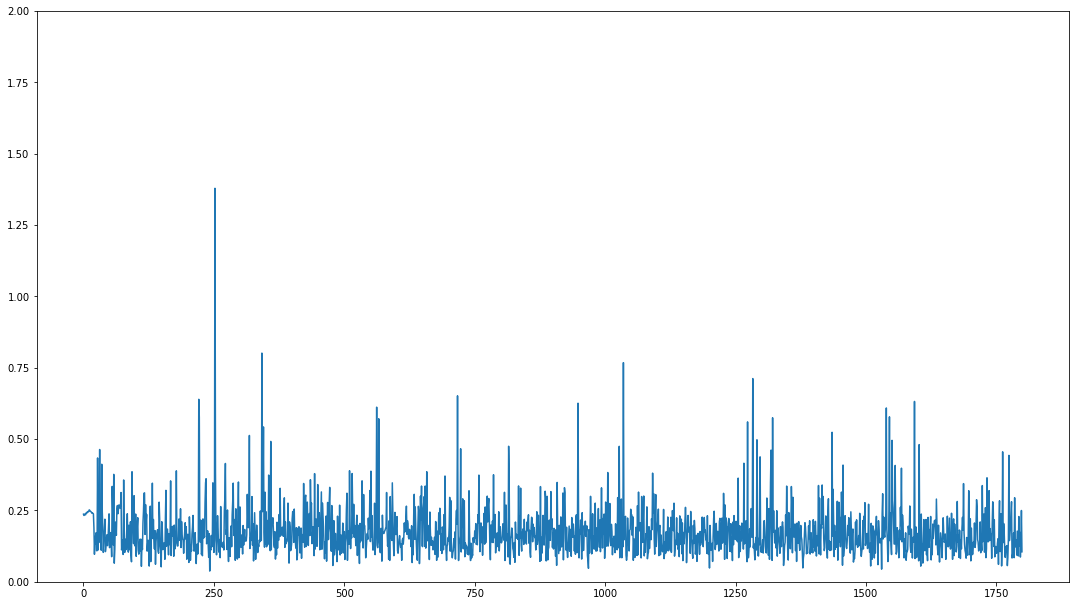

In [123]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(losses)
ax.set_ylim(0, 2)

RuntimeError: cannot call .data on a torch.Tensor: did you intend to use autograd.Variable?

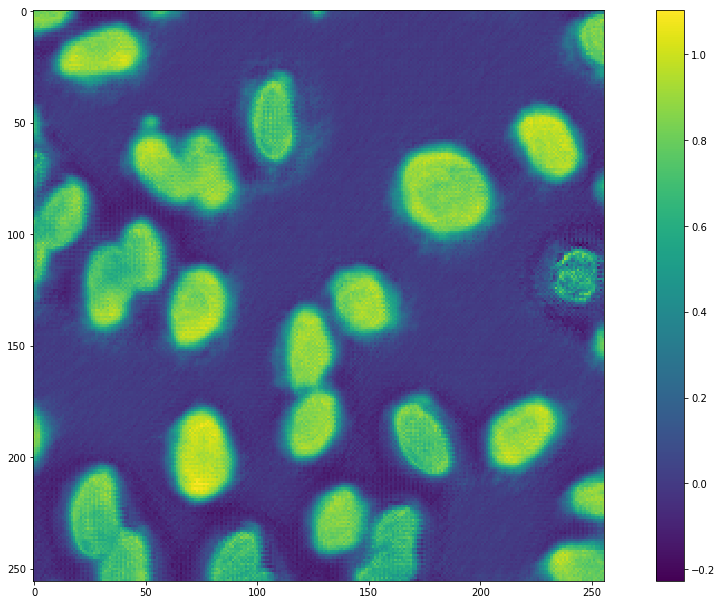

In [60]:
plot(out[0][0].cpu().data.numpy())
plot(exp[0][0].cpu().data.numpy())
plot(inp[0][0][46:-46, 46:-46].cpu().data.numpy())

plot(out[0][0].cpu().data.numpy() - exp[0][0].cpu().data.numpy())

# Validation

In [124]:
n.train(False)
loss = 0
valid_results = []
for i in range(len(validV)):
    inp = validV[i:i+1]
    inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()
    out = n(inp)[:,:,2:-2,2:-2]
    
    valid_results.append(out.data[0][0])
    
    weight = valid_weightsV[i:i+1].cuda()
    exp = valid_summary_masksV[i:i+1].cuda()
    loss += (weight * (exp - out.data)**2).mean()
    
print(loss)

91.0008382772794


None


0

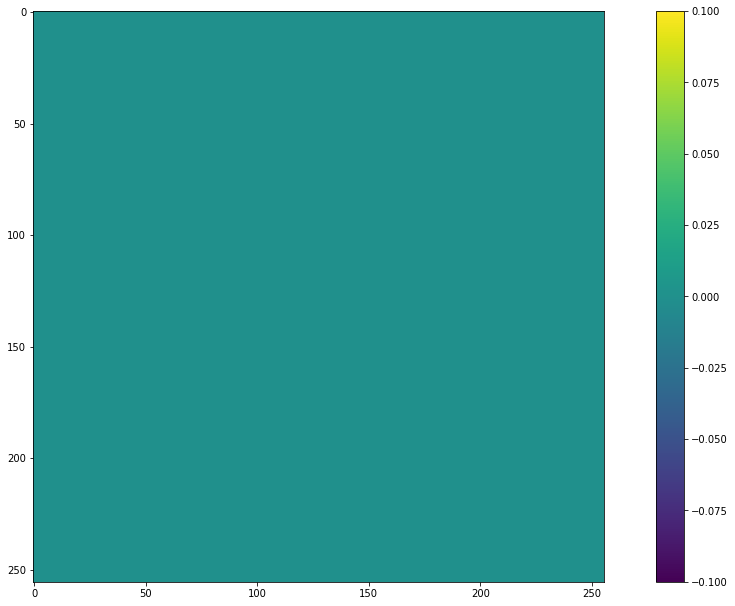

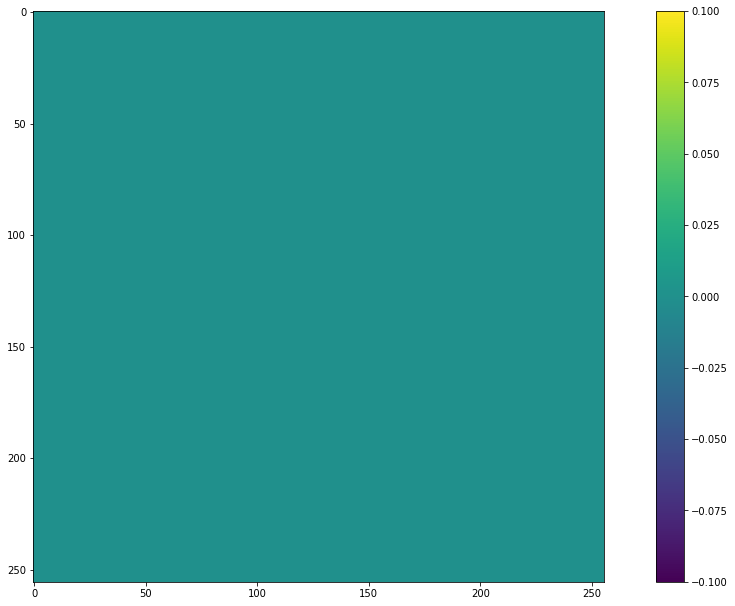

In [106]:
i = 40

"""
plot.imshow(valid_results[i])
plot.imshow(validV[i][0])
plot.imshow(valid_weightsV[i][0])
"""
pred = (valid_results[i] > 0.5).cpu().numpy()
true = valid_summary_masksV[i][0].numpy()
plot.imshow(true)
plot.imshow(pred)
iou_loss(pred, true)

0.35


/home/christopher/code/ml/data-science-bowl-2018/evaluations/iou.py:60: RuntimeWarning: divide by zero encountered in true_divide
  def _precision_at(threshold, iou):


0.36
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43000000000000005
0.44000000000000006
0.45000000000000007
0.4600000000000001
0.4700000000000001
0.4800000000000001
0.4900000000000001
0.5000000000000001
0.5100000000000001
0.5200000000000001
0.5300000000000001
0.5400000000000001
0.5500000000000002
0.5600000000000002
0.5700000000000002
0.5800000000000002
0.5900000000000002


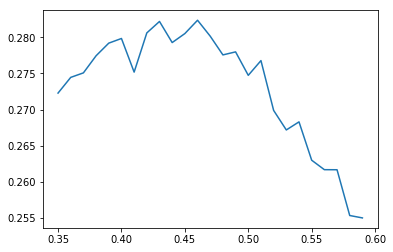

In [126]:
losses = []
cutoffs = np.arange(0.35, 0.6, 0.01)
for cutoff in cutoffs:
    print(cutoff)
    loss = 0
    for i in range(len(valid_results)):
        pred = (valid_results[i] > cutoff).cpu().numpy()
        true = valid_summary_masksV[i][0].numpy()
        l = iou_loss(pred, true)
        #print(i, l)
        loss += l
    losses.append(loss / len(valid_results))
plt.plot(cutoffs, losses)

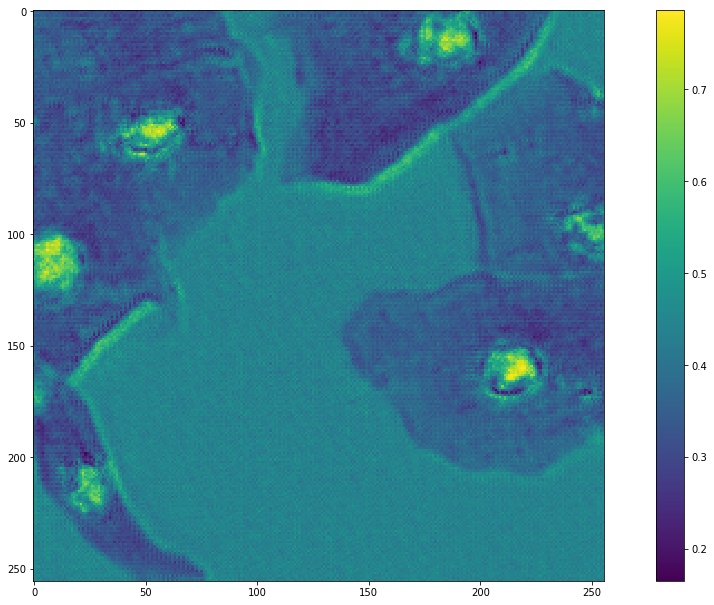

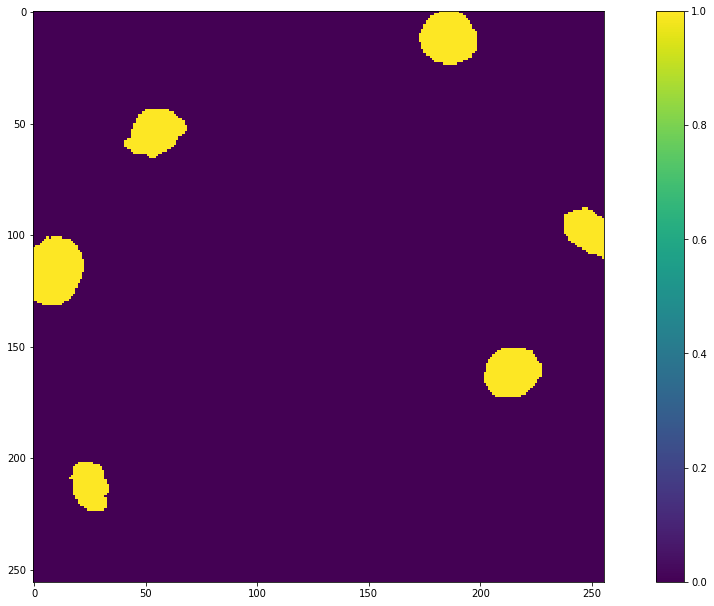

In [73]:
i = 0
plot.imshow(results[i])
plot.imshow(valid_summary_masksV[i][0])

# Test

In [112]:
test_raw, test_keys_raw = data_loaders.test_images()

In [113]:
shapes = {}
keys = {}
for i in range(len(test_raw)):
    shape = test_raw[i].shape
    try:
        shapes[shape].append(test_raw[i])
        keys[shape].append(test_keys_raw[i])
    except:
        shapes[shape] = [test_raw[i]]
        keys[shape] = [test_keys_raw[i]]

In [114]:
for k, v in shapes.items():
    shapes[k] = h.tensorfy(v)

In [115]:
shapes.keys()

dict_keys([(256, 256), (520, 348), (512, 680), (512, 640), (520, 696), (519, 161), (519, 162), (260, 347), (524, 348), (519, 253), (390, 239)])

In [127]:
n.train(False)
inp_size = 348
results, results_keys = [], []
for shp, images in shapes.items():
    y_cut, x_cut = imcut.patchify(shp)

    for img_index in range(len(images)):
        res = np.zeros(shp)
        for i in range(len(y_cut) - 1):
            for j in range(len(x_cut) - 1):
                
                height = y_cut[i+1] - y_cut[i]
                width = x_cut[j+1] - x_cut[j]
                inp = images[img_index:img_index+1,:,y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]]
                orig_shape = inp.shape
                
                width_pad = (inp_size-width)//2
                height_pad = (inp_size-height)//2
                inp = torch.nn.ReflectionPad2d(
                    (width_pad, width_pad, height_pad, height_pad),
                )(inp).cuda()
                assert inp.shape == (1, 1, inp_size, inp_size)
                
                width_unpad = (260 - width) // 2
                height_unpad = (260 - height) // 2
                out = n(inp)[:,:,height_unpad:-height_unpad,width_unpad:-width_unpad]
                assert out.shape == orig_shape
                
                res[y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]] = out.data
        results.append(res)
        results_keys.append(keys[shp][img_index])

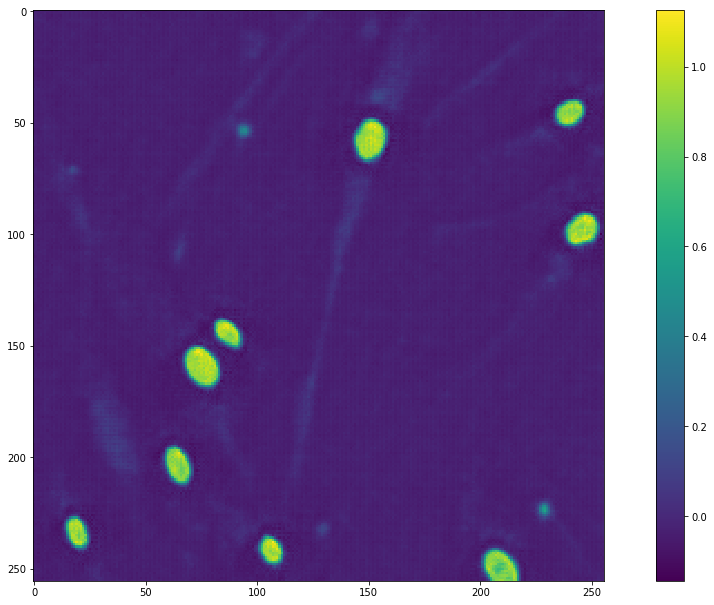

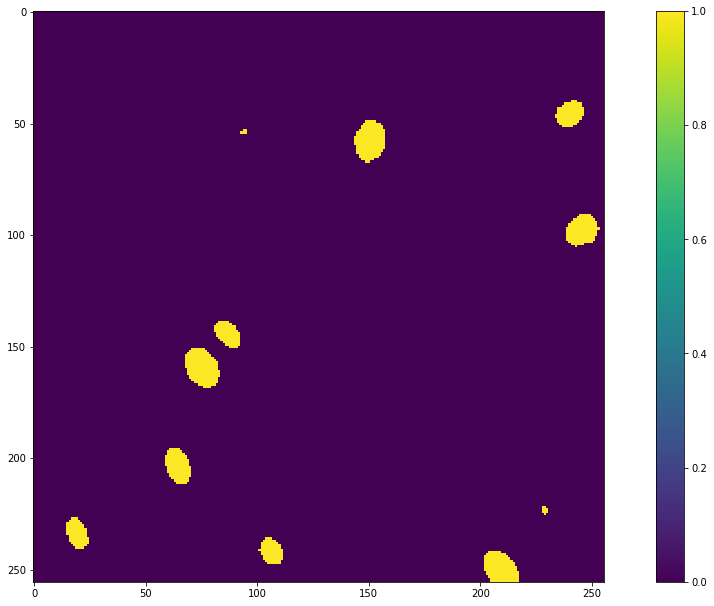

In [130]:
cutoff = 0.4
plot.imshow(results[10])
plot.imshow((results[10] > cutoff).astype(np.int))

In [131]:
prepare_submission.write_submission(
    "test_nn_out",
    [prepare_submission.remove_tiny_masks(prepare_submission.separate_masks((i > cutoff).astype(int))) for i in results],
    results_keys)

65


In [ ]:
res